In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
# import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

from sklearn.model_selection import train_test_split
import glob
import os
import math
import operator
import functools
import random
import datetime
from scipy.ndimage.interpolation import rotate, shift, zoom


In [2]:
all_X = np.load("E:\deep learning\X.npy")
all_Y = np.load("E:\deep learning\Y.npy")


In [3]:
test_size=0.15
X_train,X_test,Y_train,Y_test = train_test_split(all_X,all_Y,test_size=test_size,random_state=42)

In [4]:
print('Training shape:', X_train.shape)
print(X_train.shape[0], 'sample,',X_train.shape[1] ,'x',X_train.shape[2] ,'size grayscale image.\n')
print('Test shape:', X_test.shape)
print(X_test.shape[0], 'sample,',X_test.shape[1] ,'x',X_test.shape[2] ,'size grayscale image.\n')

Training shape: (1752, 64, 64)
1752 sample, 64 x 64 size grayscale image.

Test shape: (310, 64, 64)
310 sample, 64 x 64 size grayscale image.



In [5]:
Y_train.shape

(1752, 10)

In [6]:
Y_train_cls = np.argmax(Y_train,axis = 1)
Y_test_cls = np.argmax(Y_test,axis = 1)

In [7]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 64

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

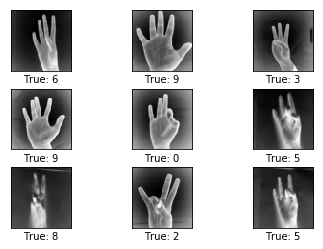

In [9]:
# Get the first images from the test-set.
images = X_test[0:9]

# Get the true classes for those images.
cls_true = Y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [10]:
train_X = X_train
train_Y = Y_train
new_train_X = train_X.reshape(X_train.shape[0],img_size_flat)
new_test_X = X_test.reshape(X_test.shape[0],img_size_flat)

In [11]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=new_train_X.shape))
print("Training set (labels) shape: {shape}".format(shape=train_Y .shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=new_test_X.shape))
print("Test set (labels) shape: {shape}".format(shape=Y_test.shape))

Training set (images) shape: (1752, 4096)
Training set (labels) shape: (1752, 10)
Test set (images) shape: (310, 4096)
Test set (labels) shape: (310, 10)


In [12]:
# architecture hyper-parameter
learning_rate = 0.001
training_iters = 40000
batch_size = 16
display_step = 20

n_input = img_size_flat # 64x64 image
dropout = 0.75 

In [13]:
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)
print('Shape of placeholder',x.shape, y.shape)

Shape of placeholder (?, 4096) (?, 10)


In [14]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [15]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [16]:
def conv_net(x, weights, biases, dropout):
    # reshape input to 64x64 size
    x = tf.reshape(x, shape=[-1, 64, 64, 1])
    

    # Convolution layer 1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max pooling
    conv1 = maxpool2d(conv1, k=2)

    # Convolution layer 2
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max pooling
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1) # layer
    fc1 = tf.nn.dropout(fc1, dropout)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [17]:
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32]),name='wc1'),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64]),name='wc2'),
    'wd1': tf.Variable(tf.random_normal([64 * 64 * 4, 1024]),name='wd1'),
    'out': tf.Variable(tf.random_normal([1024, num_classes]),name='wout')
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32]),name='bc1'),
    'bc2': tf.Variable(tf.random_normal([64]),name='bc2'),
    'bd1': tf.Variable(tf.random_normal([1024]),name='bd1'),
    'out': tf.Variable(tf.random_normal([num_classes]),name='bout')
}

In [18]:
# Create the model
model = conv_net(x, weights, biases, keep_prob)
print(model)
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
y_true_cls =  tf.argmax(y, 1)
y_pred_cls = tf.argmax(model, 1)
# This is a vector of booleans whether the predicted 
#class equals the true class of each image.
correct_model = tf.equal(y_pred_cls,y_true_cls)
# This calculates the classification accuracy by first type-casting 
#the vector of booleans to floats, so that False becomes 0 and True becomes 1,
#and then calculating the average of these numbers.
accuracy = tf.reduce_mean(tf.cast(correct_model, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

Tensor("Add_1:0", shape=(?, 10), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [19]:
def getBatch(X, Y, batchSize=16):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input train/test 
    Y --input label train/test
    
    Returns:
    mini_batches -- tuple of synchronous (mini_batch_X, mini_batch_Y)
    
    """
    arrayLength = X.shape[0]
    count = 0 
    
    while count < arrayLength/batchSize:
        random.seed(datetime.datetime.now())
        randstart = random.randint(0, arrayLength-batchSize-1)
#         print(randstart)
        count += 1
        yield (X[randstart:randstart+batchSize], Y[randstart:randstart+batchSize])

In [20]:
loss_t = []
steps_t = []
acc_t = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1   
#     Keep training until reach max iterations
    while step * batch_size < training_iters:
        a = getBatch(new_train_X,train_Y, batch_size)
        batch_x, batch_y = next(a)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        if step % display_step == 0:
            print('*'*15)
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step*batch_size) + ", Loss= " + \
                  "{:.3f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
            loss_t.append(loss)
            steps_t.append(step*batch_size)
            acc_t.append(acc)
        step += 1
    
   #
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: new_test_X,
                                      y: Y_test,
                                      keep_prob: 1.}))
    
    cls_pred = sess.run(y_pred_cls, feed_dict={x: new_test_X,
                                      y: Y_test,
                                      keep_prob: 1.})

***************
Iter 320, Loss= 40227.805, Training Accuracy= 0.188
***************
Iter 640, Loss= 30863.883, Training Accuracy= 0.062
***************
Iter 960, Loss= 19958.641, Training Accuracy= 0.250
***************
Iter 1280, Loss= 23494.125, Training Accuracy= 0.062
***************
Iter 1600, Loss= 24696.031, Training Accuracy= 0.250
***************
Iter 1920, Loss= 6762.173, Training Accuracy= 0.438
***************
Iter 2240, Loss= 5293.698, Training Accuracy= 0.688
***************
Iter 2560, Loss= 5054.792, Training Accuracy= 0.688
***************
Iter 2880, Loss= 7139.578, Training Accuracy= 0.625
***************
Iter 3200, Loss= 2361.665, Training Accuracy= 0.750
***************
Iter 3520, Loss= 3912.061, Training Accuracy= 0.812
***************
Iter 3840, Loss= 2610.066, Training Accuracy= 0.750
***************
Iter 4160, Loss= 4186.978, Training Accuracy= 0.562
***************
Iter 4480, Loss= 421.666, Training Accuracy= 0.875
***************
Iter 4800, Loss= 2121.740, Trai

***************
Iter 39360, Loss= 229.310, Training Accuracy= 0.938
***************
Iter 39680, Loss= 13.736, Training Accuracy= 0.938
Testing Accuracy: 0.8


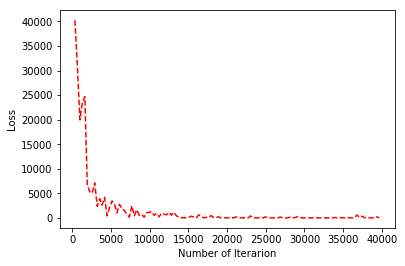

In [21]:
plt.plot(steps_t, loss_t, 'r--')
plt.xlabel("Number of Iterarion")
plt.ylabel("Loss")
plt.show()

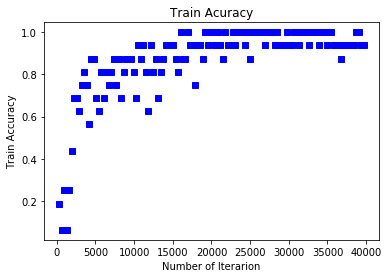

In [22]:
plt.plot(steps_t, acc_t,'bs')
plt.title("Train Acuracy")
plt.xlabel("Number of Iterarion")
plt.ylabel("Train Accuracy")
plt.show()

In [23]:
# Create a boolean array whether each image is correctly classified.
correct = (Y_test_cls == cls_pred)

# Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
correct_sum = correct.sum()
num_test = X_test.shape[0]
# Classification accuracy is the number of correctly classified
# images divided by the total number of images in the test-set.
acc = float(correct_sum) / num_test
# Print the accuracy.
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, correct_sum, num_test))

Accuracy on Test-Set: 80.0% (248 / 310)


In [24]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images =new_test_X[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = Y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])


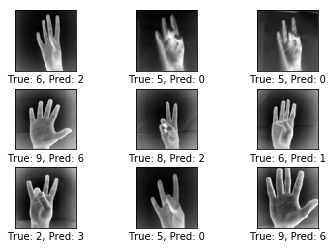

In [25]:
plot_example_errors(cls_pred=cls_pred, correct=correct)

In [26]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = Y_test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()


[[26  0  0  0  0  0  0  1  0  0]
 [ 0 31  0  0  1  0  0  0  0  0]
 [ 0  0 34  3  0  2  1  0  0  2]
 [ 0  1  4 19  0  0  3  1  0  0]
 [ 0  1  1  0 20  2  0  0  0  0]
 [ 4  0  5  0  0 14  2  0  0  3]
 [ 0  1  2  3  0  0 23  0  0  1]
 [ 0  0  0  0  0  0  0 29  0  1]
 [ 0  0  6  4  1  1  0  1 21  0]
 [ 0  0  0  0  0  0  3  1  0 31]]


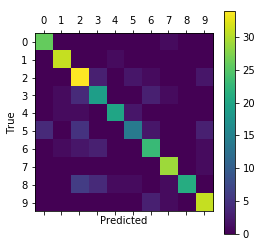

In [27]:
plot_confusion_matrix(cls_pred=cls_pred)